In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectKBest

In [2]:
PROCESSED_TRAIN = "../processed_data/feature_selection/selected_train.csv"
PROCESSED_TEST = "../processed_data/feature_selection/selected_test.csv"

In [3]:
train_df = pd.read_csv(PROCESSED_TRAIN)
test_df = pd.read_csv(PROCESSED_TEST)

In [4]:
train_df.head()

,F0semitoneFrom27.5Hz_sma3nz_stddevNorm,F0semitoneFrom27.5Hz_sma3nz_pctlrange0-2,F0semitoneFrom27.5Hz_sma3nz_meanRisingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevRisingSlope,F0semitoneFrom27.5Hz_sma3nz_meanFallingSlope,F0semitoneFrom27.5Hz_sma3nz_stddevFallingSlope,loudness_sma3_stddevNorm,loudness_sma3_percentile20.0,loudness_sma3_pctlrange0-2,loudness_sma3_meanRisingSlope,...,loudnessPeaksPerSec,VoicedSegmentsPerSec,MeanVoicedSegmentLengthSec,StddevVoicedSegmentLengthSec,MeanUnvoicedSegmentLength,StddevUnvoicedSegmentLength,equivalentSoundLevel_dBp,Participant_ID,Depression,Gender
0,0.188470,0.039394,39.990345,28.040092,100.798780,0.000000,0.409571,0.021770,0.040200,0.111894,...,1.960784,2.061856,0.240000,0.010000,0.225,0.005000,-53.529380,448,1,1
1,0.015231,0.716394,0.000000,0.000000,-0.109734,0.000000,0.619798,0.023697,0.087469,0.726745,...,3.703704,2.040816,0.080000,0.000000,0.380,0.000000,-47.326970,448,1,1
2,0.095594,4.741592,61.829530,67.673560,20.461290,11.705440,0.568298,0.055555,0.159467,2.278548,...,3.131991,2.036199,0.344444,0.235472,0.115,0.087321,-41.121784,448,1,1
3,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.283180,0.038853,0.013890,0.450482,...,3.333334,0.000000,0.000000,0.000000,0.240,0.000000,-56.265000,448,1,1
4,0.005980,0.330532,8.279264,5.828207,8.208370,6.596444,0.654023,0.083247,0.377850,2.854341,...,5.084746,1.886793,0.420000,0.000000,0.040,0.020000,-33.531155,448,1,1


In [5]:
train_df = train_df.dropna()
test_df = test_df.dropna()

In [6]:
target_col = ["Participant_ID", "Depression", "Gender"]
# target_col = "Depression"
feature_cols = list(set(train_df.columns) - set(target_col))

In [7]:
X_train = train_df[feature_cols]
y_train = train_df[target_col]

In [8]:
X_test = test_df[feature_cols]
y_test = test_df[target_col]

In [9]:
to_classify="Depression"

In [10]:
def run_tree(x_train, y_train, x_test, y_test, classify="Depression"):
    
    model = RandomForestClassifier(max_depth=63, random_state=14)
    model.fit(x_train,y_train[classify])
     
    y_test['Predicted'] = model.predict(x_test)
    y_actual = y_test.groupby("Participant_ID").agg({classify:"max"})[classify]
    y_pred = y_test.groupby("Participant_ID").agg(Predicted=('Predicted', lambda x: x.mode()[0]))["Predicted"]
    
    # Print Metrics
    print(f"Accuracy: {metrics.accuracy_score(y_actual, y_pred)}")
    print(f"Balanced_accuracy: {metrics.balanced_accuracy_score(y_actual, y_pred)}")
    print(f"Precision: {metrics.precision_score(y_actual, y_pred)}")
    print(f"Recall: {metrics.recall_score(y_actual, y_pred)}")
    print(f"F1 Score: {metrics.f1_score(y_actual, y_pred)}")
    conf_matrix = metrics.confusion_matrix(y_actual, y_pred)
    #Visualizing the confusion matrix
    plt.rcParams['figure.figsize'] = (6, 6)
    display_c_m = metrics.ConfusionMatrixDisplay(conf_matrix)
    display_c_m.plot(cmap='Greens', xticks_rotation=50)
    plt.title('Confusion Matrix')
    plt.show()

In [11]:
# Apply SelectKBest with chi2
skb = SelectKBest(k=20)
X_train_new = skb.fit_transform(X_train, y_train[to_classify])

print("Shape of X before SelectKBest:", X_train.shape)
print("Shape of X after SelectKBest:", X_train_new.shape)

Shape of X before SelectKBest: (13625, 61)
Shape of X after SelectKBest: (13625, 20)


In [12]:
selected_features = skb.get_support()
selected_features = X_train.keys()[selected_features]
print(f"Selected features: ", selected_features)

Selected features:  Index(['mfcc3_sma3_amean', 'HNRdBACF_sma3nz_amean',
       'loudness_sma3_pctlrange0-2', 'spectralFluxV_sma3nz_amean',
       'F3bandwidth_sma3nz_stddevNorm', 'loudness_sma3_stddevFallingSlope',
       'loudness_sma3_meanRisingSlope', 'mfcc4V_sma3nz_amean',
       'F1frequency_sma3nz_amean', 'spectralFlux_sma3_stddevNorm',
       'slopeV0-500_sma3nz_amean', 'jitterLocal_sma3nz_stddevNorm',
       'spectralFluxV_sma3nz_stddevNorm', 'loudness_sma3_stddevRisingSlope',
       'equivalentSoundLevel_dBp', 'loudness_sma3_meanFallingSlope',
       'loudness_sma3_percentile20.0', 'logRelF0-H1-H2_sma3nz_amean',
       'shimmerLocaldB_sma3nz_stddevNorm', 'loudness_sma3_stddevNorm'],
      dtype='object')


Accuracy: 0.65
Balanced_accuracy: 0.4642857142857143
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/var/folders/6m/wg76ryq57fnb356nt5xwlbl80000gn/T/ipykernel_85630/4154977297.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Predicted'] = model.predict(x_test)


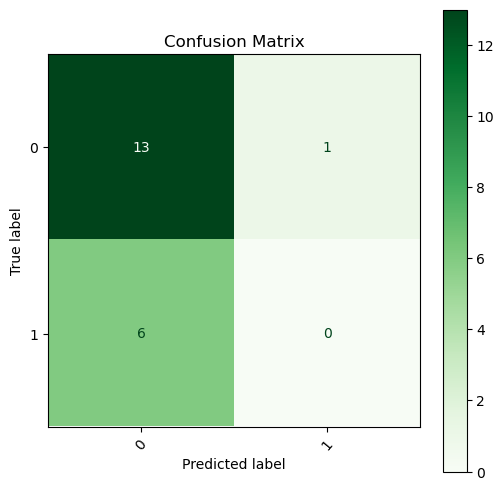

In [13]:
run_tree(X_train, y_train, X_test, y_test, to_classify)

Accuracy: 0.65
Balanced_accuracy: 0.4642857142857143
Precision: 0.0
Recall: 0.0
F1 Score: 0.0


/Users/vikram/anaconda3/lib/python3.11/site-packages/sklearn/base.py:432: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(
/var/folders/6m/wg76ryq57fnb356nt5xwlbl80000gn/T/ipykernel_85630/4154977297.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  y_test['Predicted'] = model.predict(x_test)


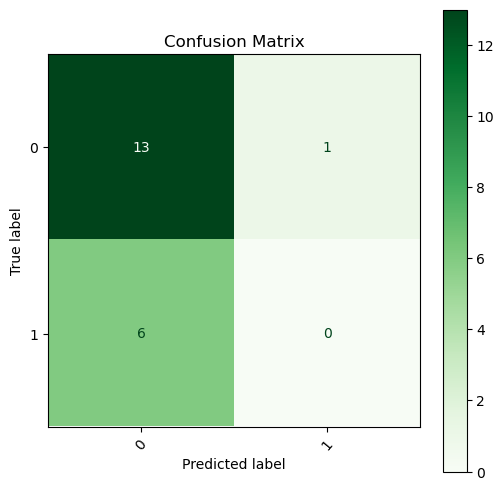

In [14]:
run_tree(X_train_new, y_train, X_test[selected_features], y_test)